# Interactive Dynesty Demo

This is a simple interactive demo that briefly goes over nested sampling and some of the features available in `dynesty`. Many of the features demonstrated here were developed specifically for Prospector.

## Setup

First, let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
import time, sys, os
import concurrent
from collections import OrderedDict
from scipy.misc import logsumexp

sys.path.append('../../dynesty/')

%pylab
%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


## Nested Sampling: Background

In standard Bayesian inference, we are interested in estimating the **posterior** $P(\boldsymbol{\Theta} | \mathbf{D}, M)$ of a set of **parameters** $\boldsymbol{\Theta}$ for a given **model** $M$ given some **data** $\mathbf{D}$. This can be factored into a form known as **Bayes' Rule** to give

$$ P(\boldsymbol{\Theta} | \mathbf{D}, M) = \frac{P(\mathbf{D} | \boldsymbol{\Theta}, M) P(\boldsymbol{\Theta} | M)}{P(\mathbf{D} | M)}$$

where $P(\mathbf{D} | \boldsymbol{\Theta}, M) \equiv \mathcal{L}(\boldsymbol{\Theta})$ is the **likelihood**, $P(\boldsymbol{\Theta}| M) \equiv \pi(\boldsymbol{\Theta})$ is the **prior**, and 

$$ P(\mathbf{D} | M) \equiv \mathcal{Z} = \int_{\Omega_{\boldsymbol{\Theta}}} \mathcal{L}(\boldsymbol{\Theta}) \pi(\boldsymbol{\Theta}) \, d\boldsymbol{\Theta} $$

is the **evidence**, where the integral is taken over the entire domain $\Omega_{\boldsymbol{\Theta}}$ of $\boldsymbol{\Theta}$ (i.e. over all possible $\boldsymbol{\Theta}$).

Nested sampling attempts to estimate $\mathcal{Z}$ by treating the integral of the posterior over all $\boldsymbol{\Theta}$ as instead an integral over the **prior volume** $X(\lambda)$ contained within **iso-likelihood contours** at $\mathcal{L}(\boldsymbol{\Theta}) = \lambda$. More formally, defining the prior volume as

$$ X(\lambda) \equiv \int_{\boldsymbol{\Theta} : \mathcal{L}(\boldsymbol{\Theta}) > \lambda} \pi(\boldsymbol{\Theta}) \, d\boldsymbol{\Theta} $$

the evidence is just

$$ \mathcal{Z} = \int_{0}^{+\infty} X(\lambda) \, d\lambda = \int_{0}^{1} \mathcal{L}(X) \, dX $$

assuming $\mathcal{L}(X(\lambda)) = \lambda$ exists. In other words, if we could evaluate the iso-likelihood contour $\mathcal{L}_i \equiv \mathcal{L}(X_i)$ associated with a bunch of samples from the prior volume $0 < X_N < \dots < X_i < \dots < X_1 < X_0 < 1$, we can compute the evidence using standard numerical integration techniques (e.g., the trapezoid rule). Computing the evidence using these "nested shells" is what gives nested sampling its name.

## Nested Sampling: How It Works

We start with a number of $K$ **"live" points** drawn from the prior $\pi(\boldsymbol{\Theta})$. At each iteration $i$, we then remove the live point with the lowest likelihood $\mathcal{L}_i$ and corresponding prior volume $X_i$ and replace it with a new live point sampled from the prior subject to the constraint $\mathcal{L}_{i+1} > \mathcal{L}_i$. It can be shown through some neat statistical arguments (which we'll return to later) that this sampling procedure actually allows us to approximate the prior volume of the previous live point (a **"dead" point**) based on the current iteration as

$$ \ln X_i \approx -i/K $$

where we've ignored some uncertainties for clarity. Given that we compute $\mathcal{L}_i$ when moving to this live point in the first place, this actually enables us to directly estimate the evidence as using a set of $N$ dead points via

$$ \mathcal{Z} \approx \hat{\mathcal{Z}} = \sum_{i=1}^{N} \mathcal{L}_i w_i $$

where $w_i = \Delta X_i$ is the associated weight. For a simple quadratic integration scheme, for instance, we can take $w_i = \frac{1}{2} (X_{i-1} - X_{i+1})$.

We can subsequently estimate posteriors "for free" by assigning each sample its associated **importance weight**

$$ P(\boldsymbol{\Theta}_i) \equiv p_i \approx \hat{p}_i = \frac{\mathcal{L}_i w_i}{\sum_{i=1}^{N} \mathcal{L}_i w_i} = \frac{\mathcal{L}_i w_i}{\hat{\mathcal{Z}}} \quad . $$

### Termination

The remaining prior volume $\Delta \mathcal{Z}_i$ can roughly be bounded by the maximum likelihood point contained within the live set $\mathcal{L}_{\max}$ multipled by the expected remaining prior volume $X_i$,

$$ \Delta \mathcal{Z}_i \approx \mathcal{L}_{\max} X_i \quad . $$

This error estimate often serves as a threshold that can be used for deciding when to terminate sampling.

### Sampling

The main requirements for nested sampling to work are:
1. that all samples used to compute/kill/replace live points are independent and
2. that all samples are drawn in proportion to the prior.

The first requirement is often not too difficult to satisfy. The second, however, is much harder to satisfy in cases where the prior is not uniform. Most nested sampling algorithms/packages (including `dynesty`) thus sample on the unit cube, which requires that you are able to transform your priors to be uniform (i.e. compute their inverse CDF).

Assuming that 1. and 2. are satisfied, the main challenge of most nested sampling implementations is coming up with ways to draw a new point as uniformly as possible without spending too much time sampling outside the prior volume. These tend to break down into two schemes: random walking away from the current set of live points or attempting to enclose the prior volume contained by all live points. The latter tends to be more popular.

## Test Case: Gaussian Shells

Let's give `dynesty` a test run over a set of Gaussian shells.

In [2]:
import dynesty

In [3]:
# Gaussian shells likelihood

# circle/shell function
def logcirc(theta, c):
    d = sqrt(sum((theta - c)**2, axis=-1))  # |theta - c|
    return const - (d - r)**2 / (2. * w**2) # log-circ

# log-likelihood function
def loglike(theta, c1, c2):
    return logaddexp(logcirc(theta, c1), logcirc(theta, c2))

# parameters
r = 2. # radius of the shells
w = 0.1 # widths of the shells
const = log(1. / sqrt(2. * pi * w**2)) # normalizing constant
c1 = np.array([-3.5, 0.]) # location of shell 1
c2 = np.array([3.5, 0.]) # location of shell 2

We now need to define the transformation that takes our uniform samples and transforms them back to the variables of interest.

In [4]:
# prior transform
def prior_transform(x):
    """Defines a flat prior between -6 and 6 in all dimensions."""
    return 12. * x - 6.

With that all set up, we can now initialize our sampler. The specific `Sampler` returned by `dynesty` depends on the specified method. Here we'll use multi-ellipsoidal decomposition.

In [24]:
# nested sampling results
f = lambda theta: loglike(theta, c1, c2)
sampler = dynesty.NestedSampler(f, prior_transform, ndim=2, method='multi_ell', nlive=1000)

Now that we've initialized our sampler, we can begin sampling from our target distribution. Sampling will continue until the specified stopping criteria are reached. We'll start by sampling until we think that the upper bound on the remaining evidence at iteration $i$ approximately satisfies $\ln(\mathcal{Z}) - \ln(\mathcal{Z}_{i}) < 0.5$.

In [25]:
sampler.sample(dlogz=0.5)
res = sampler.get_results()
print res.summary()

nlive: 1000
niter: 4092
ncall: 11425
eff(%): 39.252
logz: -1.791 +/-  0.052


That looks pretty good overall, with the estimated error somewhat smaller than our original upper bound. Let's see if we can do any better by adding more samples until an even more stringent stopping criterion is met.

In [26]:
sampler.sample(dlogz=0.01)
res2 = sampler.get_results()
print res2.summary()

nlive: 1000
niter: 7786
ncall: 20280
eff(%): 42.593
logz: -1.791 +/-  0.052


There doesn't seem to be much improvement here. What gives? Let's take a look at the weights of our samples as a function of prior volume.

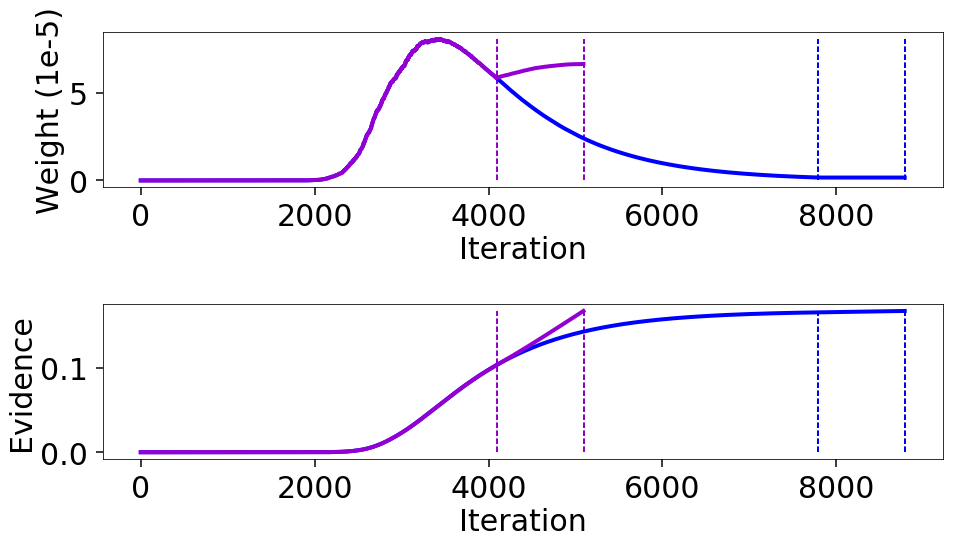

In [50]:
figure(figsize=(14,8))
subplot(211)
plot(exp(res2.logwt) * 1e5, lw=4, color='blue')
plot(exp(res.logwt) * 1e5, lw=4, color='darkviolet')
vlines([res2.niter, res2.niter + res2.nlive], 0, exp(res.logwt).max() * 1e5,
       color='blue', lw=2, linestyles='--')
vlines([res.niter, res.niter + res.nlive], 0, exp(res.logwt).max() * 1e5,
       color='darkviolet', lw=2, linestyles='--')
xlabel('Iteration')
ylabel('Weight (1e-5)')
tight_layout()
subplot(212)
plot(exp(res2.logz), lw=4, color='blue')
plot(exp(res.logz), lw=4, color='darkviolet')
vlines([res2.niter, res2.niter + res2.nlive], 0, exp(res.logz).max(),
       color='blue', lw=2, linestyles='--')
vlines([res.niter, res.niter + res.nlive], 0, exp(res.logz).max(),
       color='darkviolet', lw=2, linestyles='--')
xlabel('Iteration')
ylabel('Evidence')
tight_layout()

The culprit here is that even though our estimated error bound is computed at the end of the run, `dynesty` doesn't only use the set of dead points. Instead, it "recycles" the remaining live points when computing our final estimates (it removes them before we start sampling again), which allows us to sample past the iteration where our upper bound was computed. This matters a lot when the remaining prior volume is significant, but doesn't matter much when we've already integrated over most of the prior volume.

Let's now plot our results to see how our samples look.

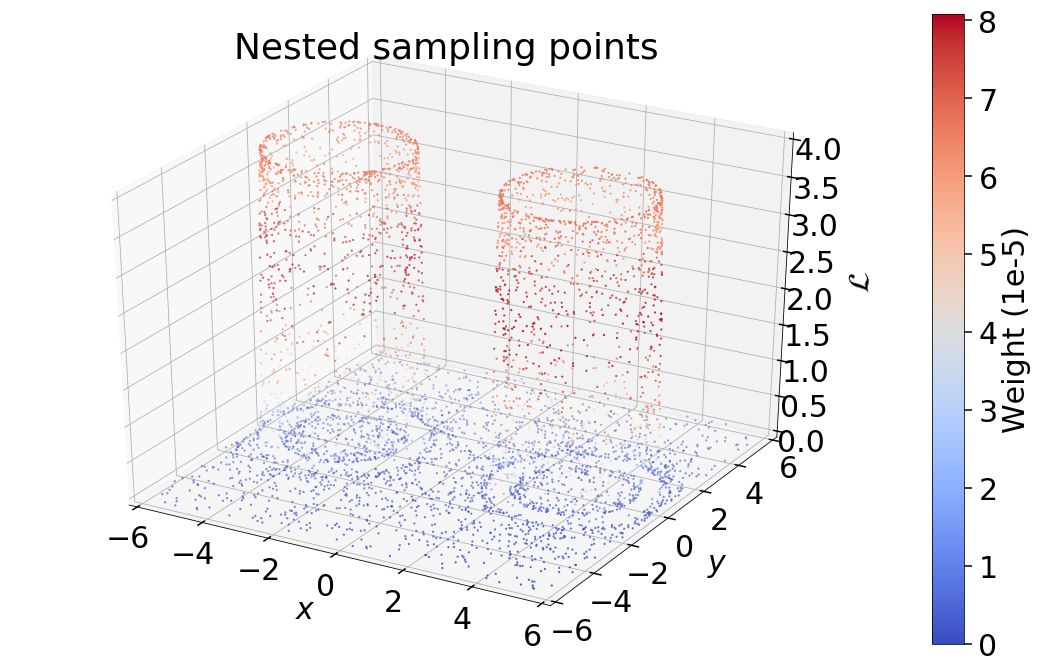

In [44]:
fig = figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(res.samples[:, 0], res.samples[:, 1], exp(res.logl),
               marker='.', c=exp(res.logwt) * 1e5, linewidths=(0.,), cmap='coolwarm')
ax.set_xlim(-6., 6.)
ax.set_xlabel(r'$x$', labelpad=25)
ax.set_ylim(-6., 6.)
ax.set_ylabel(r'$y$', labelpad=25)
ax.set_zlim(0., 4.)
ax.set_zlabel(r'$\mathcal{L}$', labelpad=25)
ax.set_title('Nested sampling points')
fig.colorbar(p, label='Weight (1e-5)')
tight_layout()

We see that the majority of the posterior weight is concentrated around the middle of the shells, a compromise between the likelihood and the change in prior volume.

## Proposals

To visualize how we're "walking up" these shells in likelihood, we can look at the evolution of our proposal over the course of the run.

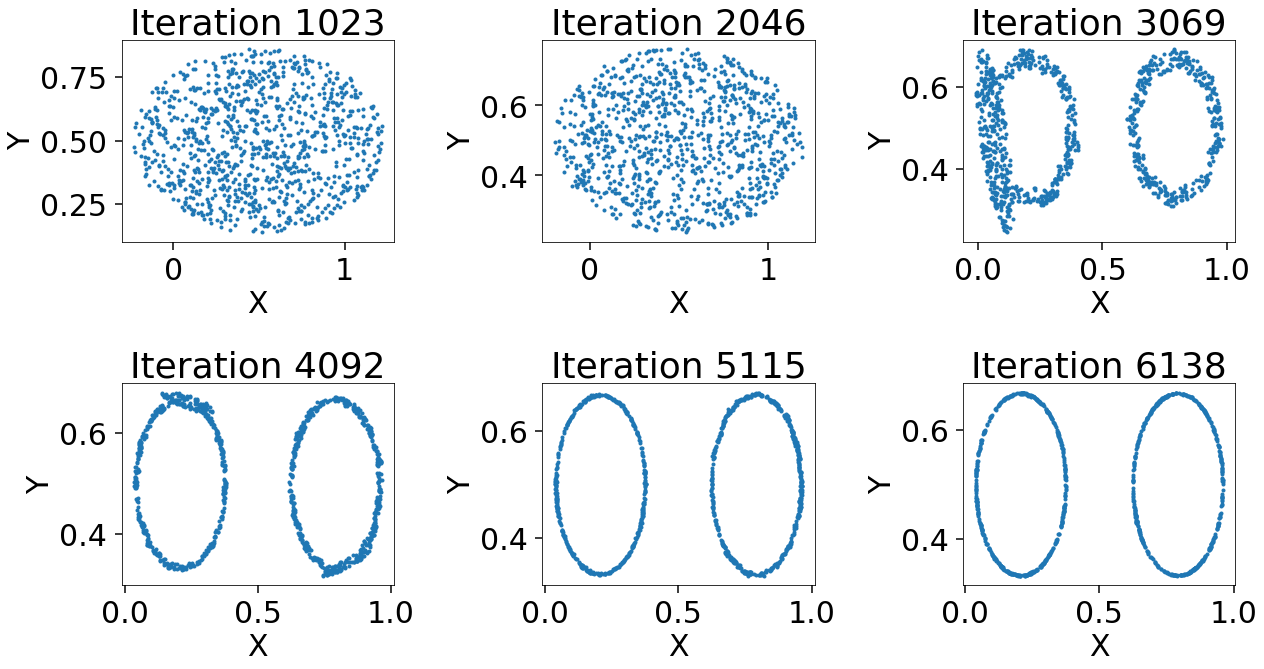

In [54]:
figure(figsize=(18, 10))
for i in xrange(6):
    subplot(2,3,i+1)
    it = int((i+1)*res.niter/4.)
    prop = sampler.get_proposal(it)
    t1, t2 = prop.samples(1000).swapaxes(0,1)
    plot(t1, t2, '.')
    xlabel('X')
    ylabel('Y')
    title('Iteration {0}'.format(it))
tight_layout()

Our multi-ellipsoid proposal is able to adapt well to the shells over time, ensuring we continue to make efficient proposals without violating our uniform sampling assumptions.

## Dimensional Scaling

Let's see how our performance scales with dimensionality here.

In [55]:
nlive = 1000

# ndim Gaussian shells
def run(ndim):
    """Convenience function for running in any dimension"""

    c1 = zeros(ndim)
    c1[0] = -3.5
    c2 = zeros(ndim)
    c2[0] = 3.5
    f = lambda theta: loglike(theta, c1, c2)
    
    sys.stdout.write("Ndim={0}...".format(ndim))
    sampler = dynesty.NestedSampler(f, prior_transform, ndim, method='multi_ell', nlive=nlive)
    sampler.sample()
    return sampler.get_results()

In [74]:
dims = array([2, 5, 10, 20]) # dimensions to sample

# analytic log-evidence values
analytic_logz = {2: -1.75,
                 5: -5.67,
                 10: -14.59,
                 20: -36.09} 
                 #30: -60.13}
                 #50: -112.42}

# compute results
results = OrderedDict()
for ndim in dims:
    t0 = time.time()
    results[ndim] = run(ndim)
    results[ndim].time = time.time() - t0
sys.stdout.write("\n")

Ndim=2...Ndim=5...Ndim=10...Ndim=20...


Let's take a look at our results.

D  analytic    logz  logzerr   nlike  eff(%)   time
 2    -1.75   -1.72     0.05    9768   41.20    1.89
 5    -5.67   -5.82     0.08   22295   36.42    4.12
10   -14.59  -14.59     0.12   48248   35.01    8.57
20   -36.09  -35.62     0.19  178740   21.20   29.82


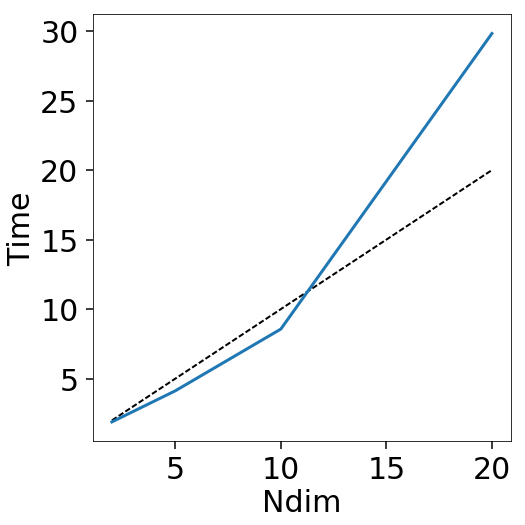

In [80]:
print("D  analytic    logz  logzerr   nlike  eff(%)   time")
for ndim, res in results.items():
    print("{:2d}   {:6.2f}  {:6.2f}     {:4.2f}  {:6d}   {:5.2f}  {:6.2f}"
          .format(ndim, analytic_logz[ndim], res.logz[-1], res.logzerr[-1],
                  sum(res.ncall)-res.nlive, res.eff, res.time))
    
figure(figsize=(10, 8))
plot(dims, dims, lw=2, color='black', ls='--')
plot(dims, [results[ndim].time for ndim in dims], lw=3)
xlabel('Ndim')
ylabel('Time')
tight_layout()

While our multi-ellipsoid rejection sampler manages to hold its own until at least 10 dimensions, it starts losing out around 20. 

## Parallelization

Although nested sampling is trivially parallelizable (in the sense that we can easily combine multiple runs together), we often would like to speed up a single run using multiple threads. Since the likelihood function is often the computational bottleneck and we often propose a number of points before updating our proposal distributions, we can use a `Pool` to "queue up" points for evaluation. This allows us to farm out the computationally intensive process of proposing new live points while keeping the serial nature of the algorithm intact.

Parallelization works better when the likelihood calls are expensive, making it computationally more expedient to try a bunch of points rather than one at a time. We'll put this in by hand here.

In [81]:
# log-likelihood function
def loglike(theta, c1, c2):
    time.sleep(1e-3)
    return logaddexp(logcirc(theta, c1), logcirc(theta, c2))

In [82]:
# parallelize ndim Gaussian shells
def parallel_run(ndim, nthreads, pool):
    """Convenience function for running in any dimension with multiple threads."""

    c1 = zeros(ndim)
    c1[0] = -3.5
    c2 = zeros(ndim)
    c2[0] = 3.5
    f = lambda theta: loglike(theta, c1, c2)
    
    sys.stdout.write("Nthreads={0}...".format(nthreads))
    sampler = dynesty.NestedSampler(f, prior_transform, ndim, method='multi_ell', nlive=nlive,
                                    queue_size=nthreads, pool=pool)
    sampler.sample()
    return sampler.get_results()

In [83]:
threads = array([1, 2, 4, 8, 16])
ndim = 5
npoints = 1000

# compute results
results = OrderedDict()
for nthreads in threads:
    t0 = time.time()
    with concurrent.futures.ThreadPoolExecutor(nthreads) as pool:
        results[nthreads] = parallel_run(ndim, nthreads, pool)
    results[nthreads].time = time.time() - t0
sys.stdout.write("\n")

Nthreads=1...Nthreads=2...Nthreads=4...Nthreads=8...Nthreads=16...


Let's now see how we're doing.

 D  N  analytic    logz  logzerr   nlike  eff(%)   time
 5   1    -5.67   -5.56     0.08   22873   34.36   33.29
 5   2    -5.67   -5.67     0.08   22222   35.88   17.06
 5   4    -5.67   -5.61     0.08   22682   34.87   10.54
 5   8    -5.67   -5.59     0.08   22331   35.33    8.37
 5  16    -5.67   -5.67     0.08   22414   35.54    8.57


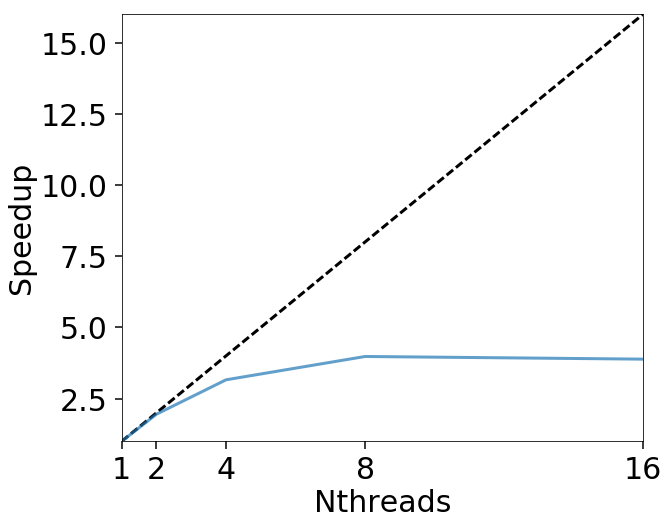

In [86]:
print(" D  N  analytic    logz  logzerr   nlike  eff(%)   time")
for nthreads, res in results.items():
    print("{:2d}  {:2d}   {:6.2f}  {:6.2f}     {:4.2f}  {:6d}   {:5.2f}  {:6.2f}"
          .format(ndim, nthreads, analytic_logz[ndim], res.logz[-1], res.logzerr[-1],
                  sum(res.ncall)-res.nlive, res.eff, res.time))
    
times = array([res.time for nthreads, res in results.items()])
speedup = times[0] / times

figure(figsize=(10,8))
plot([1, max(threads)], [1, max(threads)], color='black', ls='--', lw=3)
plot(threads, speedup, lw=3, alpha=0.7)
xlim([1, max(threads)])
ylim([1, max(threads)])
xlabel('Nthreads')
xticks(threads)
ylabel('Speedup')
tight_layout()

The falloff at $N>4$ cores here is specific to the machine I'm running these tests on, which only has 4 cores.

## Deriving Uncertainties from a Single Run

The particular statistical properties of nested sampling allow us to derive meaningful uncertainty estimates on our resulting evidence (and posteriors) using a single run. We'll go into some of the details of this below.

### Statistical Uncertainties

Nested sampling works in theory thanks to the magic of **order statistics**. At the start of our run, we sample $K$ points from the prior with likelihoods $\lbrace \mathcal{L}_1,\dots,\mathcal{L}_{K} \rbrace$ and associated prior volumes $ \lbrace X_1,\dots,X_K \rbrace$. We then want to pick the point with the maximum likelihood $\mathcal{L}_{(K)}$ out of the ordered set $\lbrace \mathcal{L}_{(1)},\dots,\mathcal{L}_{(K)} \rbrace$ with corresponding prior volume $X_{(K)}$ out of the ordered set $\lbrace X_{(1)},\dots,X_{(K)} \rbrace$. 

What is this prior volume? Well, all the points were drawn from the prior, so by the **probability integral transform (PIT)** the corresponding prior volumes are uniformly distributed **random variables** such that

$$ X_1,\dots,X_K \stackrel{i.i.d.}{\sim} \textrm{Unif} $$

where $\textrm{Unif}$ is the standard uniform distribution. It can be shown that the set of *ordered* uniformly distributed random variables (here our prior volumes) can be *jointly* represented by $K+1$ exponential random variables

$$ X_{(j)} \sim \frac{Y_1 + \cdots + Y_j}{Y_1 + \cdots + Y_{K+1}} \quad , \quad Y_1,\dots,Y_{K+1} \stackrel{i.i.d.}{\sim} \textrm{Expo} $$

where $\textrm{Expo}$ is the standard Exponential distribution.

We are interested in the marginal distribution of $X_{(K)}$ associated with $\mathcal{L}_{(K)}$, since that's the prior volume we are first sampling within. This turns out to be

$$ X_{(j=K)} \sim \textrm{Beta}(j,K-j+1) = \textrm{Beta}(K,1) $$

where $\textrm{Beta}(\alpha,\beta)$ is the Beta distribution.

Once we replace a live point with a new live point that satisfies this constraint, we now want to do the same procedure again. Using the same logic as above, we know that our prior volumes must be i.i.d. uniformly distributed *within the previous volume* (since we just replace the worst point with a new independent draw). At a given iteration $i$ where we just replaced point $i-1$ with prior volume $X_{i-1}$, the prior volume associated with a new $X_i$ we're now trying to remove is then

$$ X_i \sim t_i X_{i-1} ~,~ t_i \sim \textrm{Beta}(K,1) \quad \Rightarrow \quad X_i \sim \prod_{j=1}^{i} t_j ~,~ t_1,\dots,t_i \stackrel{i.i.d.}{\sim} \textrm{Beta}(K,1) \quad \Rightarrow \quad \ln X_i = \sum_{j=1}^{i} \ln t_i \quad . $$

Once the algorithm terminantes after $N$ iterations using some stopping criteria, we are then left with a set of $K$ live points and a final set of $\lbrace X_{N+1}=X_{(1)}, \dots, X_{N+K}=X_{(K)} \rbrace$ prior volumes. Going back to our earlier results from order statistics, we can jointly represent the ratio of their volumes with respect to $X_N$ as

$$ \frac{X_{N+j}}{X_N} \sim \frac{Y_1 + \cdots + Y_{K-j+1}}{Y_1 + \dots + Y_{K+1}} \quad . $$

Since we're probing many points during a nested sampling run, we can roughly approximate the evidence distribution using the first two (geometric) moments 

$$ E[\ln X_i] = \sum_{j=1}^{i} E[\ln t_i] = \sum_{j=1}^{i} -1/K = -i/K \quad , \quad \textrm{Var}[\ln X_i] = \sum_{j=1}^{i} \textrm{Var}[\ln t_i] = \sum_{j=1}^{i} 1/K = i/K $$

giving us 

$$ \ln X_i \approx \left. - \left(i \pm \sqrt{i}\right) \middle/ K \right. \quad , $$

which are the uncertainties generally reported by `dynesty`.

### Sampling Uncertainties

In addition to the statistical uncertainties associated with the unknown prior volumes, nested sampling is also subject to sampling uncertainties due to the particular path taken through the prior by a particular live point. In other words, although the volume $X_i$ at a given iteration $i$ can be known, the particular position $\boldsymbol{\Theta}_i$ on the iso-likelihood contour is randomly distributed. This adds some additional noise to our posterior estimates. This can also add noise to our evidence if there are problems with our particular proposal distribution that violate our assumptions above (e.g., our expected prior volume shrinkage is not the actual shrinkage).

We can probe these uncertainties by applying the "trivially parallelizable" nature of nested sampling in reverse. In particular, the particular path a particular live point $i$ takes through the prior is fully independent of the paths of all the other live points. This means we can decompose our run with $K$ live points into $K$ runs with one live point. We can then derive sampling uncertainties by bootstrap resampling these $K$ **"strands"**, re-combining them into one run, and seeing how much our evidence varies.

### Tests

Let's see how well our first and second-moment approximations are. `dynesty` has functions that allow us to simulate our statistical uncertainties (via `utils.simulate_run`), statistical uncertainties (via `utils.resample_run`), and both uncertainties jointly (via `utils.sample_run`). First let's check out the evidence.

In [89]:
# log-likelihood function
def loglike(theta, c1, c2):
    return logaddexp(logcirc(theta, c1), logcirc(theta, c2))

# parameters
r = 2. # radius of the shells
w = 0.1 # widths of the shells
const = log(1. / sqrt(2. * pi * w**2)) # normalizing constant
c1 = np.array([-3.5, 0.]) # location of shell 1
c2 = np.array([3.5, 0.]) # location of shell 2

# run sampler
f = lambda theta: loglike(theta, c1, c2)
sampler = dynesty.NestedSampler(f, prior_transform, ndim=2, method='multi_ell', nlive=1000)
sampler.sample(dlogz=0.5)
res = sampler.get_results()
print res.summary()

nlive: 1000
niter: 4047
ncall: 11792
eff(%): 37.500
logz: -1.747 +/-  0.051


In [97]:
Nmc = 250
logz_sim = array([dynesty.utils.simulate_run(res).logz[-1] for i in xrange(Nmc)])
logz_resamp = array([dynesty.utils.resample_run(res).logz[-1] for i in xrange(Nmc)])
logz_samp = array([dynesty.utils.sample_run(res).logz[-1] for i in xrange(Nmc)])
print 'Original:  {0} +/- {1}'.format(res.logz[-1], res.logzerr[-1])
print 'Simulated: {0} +/- {1}'.format(mean(logz_sim), std(logz_sim))
print 'Resampled: {0} +/- {1}'.format(mean(logz_resamp), std(logz_resamp))
print 'Both:      {0} +/- {1}'.format(mean(logz_samp), std(logz_samp))

Original:  -1.74711448561 +/- 0.0513131102057
Simulated: -1.74995692353 +/- 0.0523530117873
Resampled: -1.74228618513 +/- 0.0496542446466
Both:      -1.74006700372 +/- 0.0760880035277


How about our posteriors? Let's see what those moments look like.

In [116]:
post_sim = empty((Nmc, 2))
post_resamp = empty((Nmc, 2))
post_samp = empty((Nmc, 2))

for i in xrange(Nmc):
    r = dynesty.utils.simulate_run(res)
    post_sim[i] = average(r.samples, weights=exp(r.logwt), axis=0)
    r = dynesty.utils.resample_run(res)
    post_resamp[i] = average(r.samples, weights=exp(r.logwt), axis=0)
    r = dynesty.utils.sample_run(res)
    post_samp[i] = average(r.samples, weights=exp(r.logwt), axis=0)

pmean, pcov = dynesty.utils.mean_and_cov(res.samples, exp(res.logwt))
    
print 'Posterior moments: {0} +/- {1}'.format(pmean, diag(pcov))
print 'Simulated [means]: {0} +/- {1}'.format(mean(post_sim, axis=0), std(post_sim, axis=0))
print 'Resampled [means]: {0} +/- {1}'.format(mean(post_resamp, axis=0), std(post_resamp, axis=0))
print 'Both [means]:      {0} +/- {1}'.format(mean(post_samp, axis=0), std(post_samp, axis=0))

Posterior moments: [-0.06973899  0.01579419] +/- [ 14.31784389   2.0431241 ]
Simulated [means]: [-0.07430029  0.01632259] +/- [ 0.05466733  0.02020086]
Resampled [means]: [-0.06756096  0.01921547] +/- [ 0.07239903  0.02558944]
Both [means]:      [-0.07160606  0.01850045] +/- [ 0.09201208  0.03644864]


We see a larger increase in our posterior errors from resampling then we do from our simulated weights, although compared to the actual posterior this amount of error only amounts to an additional smoothing of ~1-2%.